In [2]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import warnings
from collections import Counter
warnings.filterwarnings("ignore")


In [15]:
wc = WordCloud().generate_from_frequencies({"fool":12, "debt":3, "eric":7})

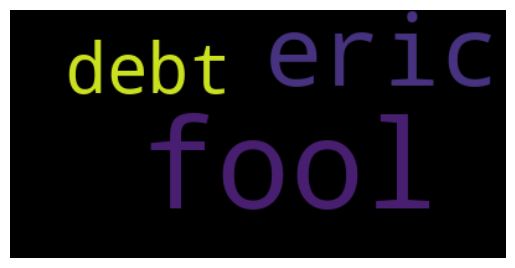